# Traveling during incertain times: GRU Airport flights from and to Europe

International flights were severely affected by the pandemic. Even though it is not the best time to travel, some people still have to go back to their homes, go back to school or even travel for professional reasons. For those who study abroad, July and August are specially important since the academic year in Europe starts on September.

This project intend to help people that need to go to Europe or Brazil during these times, and need to understand what is happening on the airports in terms of confirmed and canceled flights, and airline's operations. This analysis also offers insights about which airports/cities in Europe had more confirmed/canceled flights.

The dataset was found on the Anac website and it contains all flights from and to airports in Brazil during June 2020.
By the time of this analysis it was the newest data avaiable.

This analysis focus on flights made bewtween Guarulhos Airport and Airports in Europe.

### This project in a nutshell:

- KLM, Latam and Britsh Airways were in the top 3 companies that made flights from and to Europe. 
- Frankfurt, London and Amsterdam were the main destinations and departures for confirmed flights.
- 6.9% of flights for Europe were canceled against 14,9% from Europe to GRU.


## First Look

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 

In [3]:
#Read in the data
data = pd.read_csv('VRA_06_2020.csv', sep=';')

#Exploration
data.head()

,ICAO Empresa Aerea,Numero Voo,Codigo DI,Codigo Tipo Linha,ICAO Aerodromo Origem,ICAO Aerodromo Destino,Partida Prevista,Partida Real,Chegada Prevista,Chegada Real,Situacao Voo
0,AAL,9715,2,X,KMIA,SBGR,08/06/2020 16:50,08/06/2020 20:46,09/06/2020 02:40,09/06/2020 05:17,REALIZADO
1,AAL,9715,2,X,KMIA,SBGR,09/06/2020 19:50,09/06/2020 20:59,10/06/2020 05:35,10/06/2020 05:31,REALIZADO
2,AAL,9715,2,X,KMIA,SBGR,11/06/2020 19:50,11/06/2020 21:00,12/06/2020 05:35,12/06/2020 05:25,REALIZADO
3,AAL,9715,2,X,KMIA,SBGR,14/06/2020 19:50,14/06/2020 20:46,15/06/2020 05:35,15/06/2020 05:01,REALIZADO
4,AAL,9715,2,X,KMIA,SBGR,15/06/2020 19:50,15/06/2020 20:43,16/06/2020 05:35,16/06/2020 05:02,REALIZADO


Since we are focusing on airlines and flight status, let's keep just the columns that are interesting for the analysis

In [5]:
#Dropping unecessary columns

data = data.drop(["Codigo DI", "Codigo Tipo Linha", "Partida Real", "Chegada Prevista", "Chegada Real"], axis=1)                      

In [7]:
#Checking for nulls
data.isnull().sum()

ICAO Empresa Aerea          0
Numero Voo                  0
ICAO Aerodromo Origem       0
ICAO Aerodromo Destino      0
Partida Prevista          164
Situacao Voo                0
dtype: int64

In [8]:
#Checking for nulls in other forms
data["Situacao Voo"].value_counts()

REALIZADO        11483
CANCELADO         1287
NAO INFORMADO       30
Name: Situacao Voo, dtype: int64

The status information about the flight is crutial to the analysis. Due to that, we are going to drop rows that don't have this information.

In [15]:
#Dropping columns with flight status "Nao Informado"
data = data[data["Situacao Voo"] != "NAO INFORMADO"]

In [65]:
#Renaming columns

new_names = { "ICAO Empresa Aerea" : "airline", "Numero Voo": "flight_number", "ICAO Aerodromo Origem": "airport_departure", 
             "ICAO Aerodromo Destino" : "airport_arrival", "Partida Prevista": "est_departure_time", "Situacao Voo": "status"}

data.rename(new_names, inplace=True, axis=1)


In [68]:
#Checking the names
data.columns

Index(['airline', 'flight_number', 'airport_departure', 'airport_arrival',
       'est_departure_time', 'status'],
      dtype='object')

## Getting extra information about airports 

In [26]:
#Read in complementary data
info = pd.read_excel('glossario_de_aerodromo.xls', header=3)

In [30]:
info.head(-10)

,Unnamed: 0,Sigla OACI,Descrição,Cidade,UF,País,Continente
0,NaN,1AON,OUROLANDIA DO NORTE,OURILANDIA DO NORTE,PA,BRASIL,AMERICA DO SUL
1,NaN,2NHT,HOTEL TRANSAMÉRICA,UNA,BA,BRASIL,AMERICA DO SUL
2,NaN,6ASO,SORRISO,SORRISO,MT,BRASIL,AMERICA DO SUL
3,NaN,CYMX,MONTREAL-MIRABEL INTERNATIONAL AIRPORT,MIRABEL,NaN,CANADA,AMERICA DO NORTE
4,NaN,CYQB,QUEBEC CITY JEAN LESAGE INTERNATIONAL AIRPORT,QUEBEC JEAN LESAGE INTL,NaN,CANADA,AMERICA DO NORTE
...,...,...,...,...,...,...,...
796,NaN,TTPP,PIARCO INTERNATIONAL AIRPORT,PORT OF SPAIN,NaN,TRINIDAD E TOBAGO,AMERICA CENTRAL
797,NaN,UKBB,BORYSPIL INTERNATIONAL AIRPORT,KIEV BORISPOL,NaN,UCRANIA,EUROPA
798,NaN,UUEE,SHEREMETYEVO INTERNATIONAL AIRPORT,MOSCOU,NaN,RUSSIA,EUROPA
799,NaN,UUWW,VNUKOVO AIRPORT,MOSCOW VNUKOVO,NaN,RUSSIA,EUROPA


In [32]:
#Filtering for information about Europe
info = info[info.Continente == "EUROPA"]

In [56]:
#Getiing the list of airports in Europe
airports = info["Sigla OACI"].unique().tolist()

In [61]:
#Getting airport names and description
airports_names = info[info["Sigla OACI"] == airports]
airport_descriptions = airports_names[["Sigla OACI","Descrição"]]

## Preparing and filtering data for analysis

- **First filter: Flights from Brazil to Europe**

In [70]:
#Filtering all flights in Brazil with Europe as destination
data_to_europe = data[data["airport_arrival"].isin(airports)]

In [81]:
#Filtering all flights from Europe to Brazil
data_from_europe = data[data["airport_departure"].isin(airports)]

**1.Flights from Guarulhos to Europe**

In [74]:
data_gru_to_eu = data_to_europe[data_to_europe['airport_departure'] == "SBGR"]

In [75]:
data_gru_to_eu

,airline,flight_number,airport_departure,airport_arrival,est_departure_time,status
57,AFR,443,SBGR,LFPG,04/06/2020 15:25,CANCELADO
81,AFR,457,SBGR,LFPG,02/06/2020 15:10,REALIZADO
82,AFR,457,SBGR,LFPG,05/06/2020 15:10,REALIZADO
83,AFR,457,SBGR,LFPG,07/06/2020 15:10,REALIZADO
84,AFR,457,SBGR,LFPG,09/06/2020 15:10,REALIZADO
...,...,...,...,...,...,...
12183,TAP,9560,SBGR,LPPT,21/06/2020 07:05,REALIZADO
12184,TAP,9560,SBGR,LPPT,07/06/2020 07:05,CANCELADO
12185,TAP,9560,SBGR,LPPT,17/06/2020 07:05,CANCELADO
12186,TAP,9560,SBGR,LPPT,03/06/2020 07:20,REALIZADO


- Confirmed Flights from Guarulhos to Europe

In [76]:
confirmed_gru_to_eu = data_gru_to_eu[data_gru_to_eu["status"] == "REALIZADO"]

In [80]:
confirmed_gru_to_eu["airline"].value_counts()

KLM    24
BAW    23
TAM    22
DLH    22
AFR    20
TAP    17
SWR     7
Name: airline, dtype: int64

- Cancelled flights from Guarulhos to Europe

In [78]:
canceled_gru_to_eu = data_gru_to_eu[data_gru_to_eu["status"] == "CANCELADO"]

In [79]:
canceled_gru_to_eu

,airline,flight_number,airport_departure,airport_arrival,est_departure_time,status
57,AFR,443,SBGR,LFPG,04/06/2020 15:25,CANCELADO
3926,BAW,3583,SBGR,EGLL,02/06/2020 16:30,CANCELADO
3927,BAW,3583,SBGR,EGLL,08/06/2020 16:30,CANCELADO
3928,BAW,3583,SBGR,EGLL,15/06/2020 16:30,CANCELADO
3947,CCA,908,SBGR,LEMD,04/06/2020 18:05,CANCELADO
3948,CCA,908,SBGR,LEMD,07/06/2020 18:05,CANCELADO
3949,CCA,908,SBGR,LEMD,11/06/2020 18:05,CANCELADO
3950,CCA,908,SBGR,LEMD,14/06/2020 18:05,CANCELADO
12184,TAP,9560,SBGR,LPPT,07/06/2020 07:05,CANCELADO
12185,TAP,9560,SBGR,LPPT,17/06/2020 07:05,CANCELADO


**2. Flights from Europe to Guarulhos**

In [83]:
data_eu_to_gru = data_from_europe[data_from_europe["airport_arrival"] == "SBGR"]

In [84]:
data_eu_to_gru

,airline,flight_number,airport_departure,airport_arrival,est_departure_time,status
61,AFR,454,LFPG,SBGR,01/06/2020 18:35,REALIZADO
62,AFR,454,LFPG,SBGR,04/06/2020 18:35,REALIZADO
63,AFR,454,LFPG,SBGR,06/06/2020 18:35,REALIZADO
64,AFR,454,LFPG,SBGR,08/06/2020 18:35,REALIZADO
65,AFR,454,LFPG,SBGR,11/06/2020 18:35,REALIZADO
...,...,...,...,...,...,...
12194,TAP,9561,LPPT,SBGR,10/06/2020 07:00,CANCELADO
12195,TAP,9561,LPPT,SBGR,03/06/2020 06:45,REALIZADO
12196,TAP,9561,LPPT,SBGR,19/06/2020 06:45,REALIZADO
12197,TAP,9561,LPPT,SBGR,22/06/2020 06:45,REALIZADO


- Confirmed Flights from Europe to Guarulhos

In [85]:
confirmed_from_eu = data_eu_to_gru[data_eu_to_gru["status"] == 'REALIZADO']

In [86]:
confirmed_from_eu

,airline,flight_number,airport_departure,airport_arrival,est_departure_time,status
61,AFR,454,LFPG,SBGR,01/06/2020 18:35,REALIZADO
62,AFR,454,LFPG,SBGR,04/06/2020 18:35,REALIZADO
63,AFR,454,LFPG,SBGR,06/06/2020 18:35,REALIZADO
64,AFR,454,LFPG,SBGR,08/06/2020 18:35,REALIZADO
65,AFR,454,LFPG,SBGR,11/06/2020 18:35,REALIZADO
...,...,...,...,...,...,...
12192,TAP,9561,LPPT,SBGR,17/06/2020 06:45,REALIZADO
12195,TAP,9561,LPPT,SBGR,03/06/2020 06:45,REALIZADO
12196,TAP,9561,LPPT,SBGR,19/06/2020 06:45,REALIZADO
12197,TAP,9561,LPPT,SBGR,22/06/2020 06:45,REALIZADO


- Canceled flights from Europe to Guarulhos

In [87]:
canceled_from_eu = data_eu_to_gru[data_eu_to_gru["status"] == 'CANCELADO']

In [88]:
canceled_from_eu 

,airline,flight_number,airport_departure,airport_arrival,est_departure_time,status
3899,BAW,247,EGLL,SBGR,18/06/2020 18:25,CANCELADO
3900,BAW,247,EGLL,SBGR,30/06/2020 18:25,CANCELADO
3921,BAW,247,EGLL,SBGR,10/06/2020 18:25,CANCELADO
3923,BAW,3582,EGLL,SBGR,01/06/2020 17:25,CANCELADO
3924,BAW,3582,EGLL,SBGR,07/06/2020 17:25,CANCELADO
3925,BAW,3582,EGLL,SBGR,14/06/2020 17:25,CANCELADO
3935,CCA,907,LEMD,SBGR,04/06/2020 03:45,CANCELADO
3936,CCA,907,LEMD,SBGR,07/06/2020 03:45,CANCELADO
3937,CCA,907,LEMD,SBGR,11/06/2020 03:45,CANCELADO
3938,CCA,907,LEMD,SBGR,14/06/2020 03:45,CANCELADO


## Analyzing flights from GRU Airport to Europe in June 2020

In [217]:
#Status overview

pie1 = data_gru_to_eu["status"].value_counts().copy().to_frame().reset_index()
fig = px.pie(pie1, values='status', names='index', color_discrete_sequence=px.colors.diverging.Temps, title = "GRU to Europe: confirmed vs. canceled")
fig.show()

- **Which airlines had flights to Europe?**

Text(0.5, 1.0, 'Airlines with most confirmed flights to Europe')

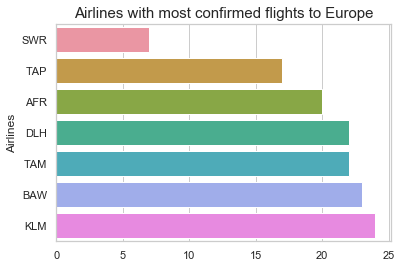

In [227]:
#Confirmed: airlines

#Set style for all plots
sns.set_style("whitegrid")
sns.set_palette("Spectral")

plot1 = confirmed_gru_to_eu.pivot_table(index="airline", values="status", aggfunc='count').sort_values(by='status')
ax = sns.barplot(plot1.status, plot1.index)
ax.set(xlabel='', ylabel='Airlines')
ax.set_title("Airlines with most confirmed flights to Europe", fontsize=15)

- **Which airlines had most canceled flghts?**

Text(0.5, 1.0, 'Airlines with most canceled flights to Europe')

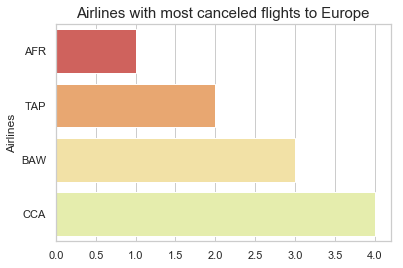

In [225]:
#Canceled: airlines
plot2 = canceled_gru_to_eu.pivot_table(index="airline", values="status", aggfunc='count').sort_values(by='status')
ax2 = sns.barplot(plot2.status, plot2.index)
ax2.set(xlabel='', ylabel="Airlines")
ax2.set_title("Airlines with most canceled flights to Europe", fontsize=15)

- **What were the most frequent destinations?**

Text(0.5, 1.0, 'GRU to Europe: confirmed destinations')

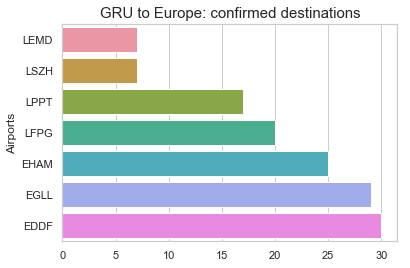

In [210]:
#Confirmed: destination

plot3 =confirmed_gru_to_eu.pivot_table(index="airport_arrival", values="status", aggfunc='count').sort_values(by='status')
ax3 = sns.barplot(plot3.status, plot3.index)
ax3.set(xlabel='', ylabel="Airports")
ax3.set_title("GRU to Europe: confirmed destinations", fontsize=15)

- **What were the most frequent destinations for canceled flights?**

Text(0.5, 1.0, 'GRU to Europe: canceled destinations')

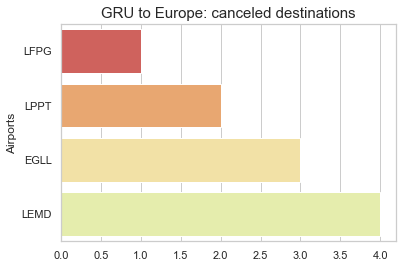

In [211]:
#Canceled: destination
plot4 = canceled_gru_to_eu.pivot_table(index="airport_arrival", values="status", aggfunc='count').sort_values(by='status')
ax4 = sns.barplot(plot4.status, plot4.index)
ax4.set(xlabel='', ylabel="Airports")
ax4.set_title("GRU to Europe: canceled destinations", fontsize=15)

## Analyzing flights from Europe to GRU in June 2020


In [218]:
#Status overview
pie2 = data_eu_to_gru["status"].value_counts().copy().to_frame().reset_index()
fig2 = px.pie(pie2, values='status', names='index', color_discrete_sequence=px.colors.diverging.Temps, title= "Europe to GRU: confirmed vs. canceled")
fig2.show()


- **Which airlines had flights to GRU?**

Text(0.5, 1.0, 'Airlines with confirmed flights from Europe')

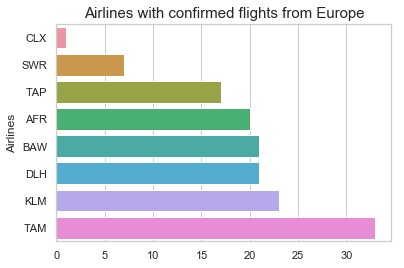

In [228]:
plot5 = confirmed_from_eu.pivot_table(index="airline", values="status", aggfunc='count').sort_values(by='status')
ax5 = sns.barplot(plot5.status, plot5.index)
ax5.set(xlabel='', ylabel='Airlines')
ax5.set_title("Airlines with confirmed flights from Europe", fontsize=15)

- **From which airport?**

Text(0.5, 1.0, 'Airports with most confirmed flights from Europe')

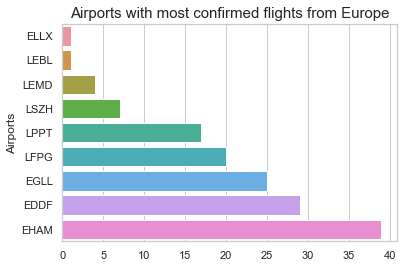

In [229]:
plot6 = confirmed_from_eu.pivot_table(index="airport_departure", values="status", aggfunc='count').sort_values(by='status')
ax6 = sns.barplot(plot6.status, plot6.index)
ax6.set(xlabel='', ylabel='Airports')
ax6.set_title("Airports with most confirmed flights from Europe", fontsize=15)

- **Which airlines had canceled flights from Europe to Guarulhos?**

Text(0.5, 1.0, 'Airlines with most canceled flights from Europe')

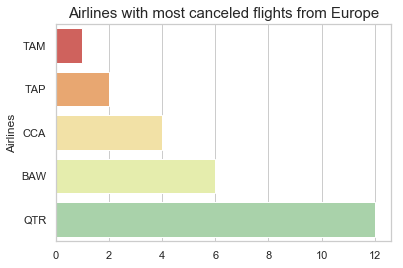

In [223]:
plot7 = canceled_from_eu.pivot_table(index="airline", values="status", aggfunc='count').sort_values(by='status')
ax7 = sns.barplot(plot7.status, plot7.index)
ax7.set(xlabel='', ylabel='Airlines')
ax7.set_title("Airlines with most canceled flights from Europe", fontsize=15)

- **From which cities?**

Text(0.5, 1.0, 'Airports with most canceled flights from Europe')

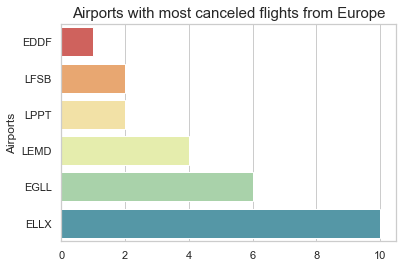

In [224]:
plot8 = canceled_from_eu.pivot_table(index="airport_departure", values="status", aggfunc='count').sort_values(by='status')
ax8 = sns.barplot(plot8.status, plot8.index)
ax8.set(xlabel='', ylabel='Airports')
ax8.set_title("Airports with most canceled flights from Europe", fontsize=15)

## Conclusions

**Overview:** There were more canceled flights from Europe to Guarulhos than the opposite. For both directions, the percentage of canceled flights were below 15%. 

**From GRU:**
- KLM, British Airways, and Latam had over 20 flights each one to Europe in June 2020.
- In general, the most frequent destinations were Frankfurt, London, and Amsterdam. 
- There were 10 canceled flights in June, 4 of them operated by Air China.
- Madrid was the most affected destination by the cancelations.

**From Europe**:

- Latam, Lufhansa and KLM were the companies with most confimed flights to Guarulhos.
- Amsterdam was the most frequent airport departure, with more than 35 flights.
- Qtar Airlines had 12 fights canceled to Guarulhos.
- The european airport with most canceled flights was in Luxemburg.    